In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mypackage import Strategy_Manager, Strategy, Backtester, compare_results, strategy, DataFileReader

filepath = 'data.parquet'
filepath = 'fichier_donnée.csv'

# Initialiser le lecteur de fichiers
reader = DataFileReader()

# Utilisation basique - détection automatique de la colonne de date
#data = reader.read_file(filepath)

# Ou en spécifiant la colonne de date facultatif
# Ou en spécifiant un format de date particulier

reader = DataFileReader(date_format='%d/%m/%Y')
data = reader.read_file(filepath, date_column='Date_Price')
data = data[data.columns.to_list()[:10]]
all_asset = data.columns.to_list()


In [2]:
class MovingAverageCrossover(Strategy):
    """Stratégie de croisement de moyennes mobiles pour plusieurs actifs."""
    
    def __init__(self, assets, short_window=20, long_window=50, rebalancing_frequency='D', 
                 allocation_method='equal'):
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.short_window = short_window
        self.long_window = long_window
        self.allocation_method = allocation_method

    def get_position(self, historical_data, current_position):
        if len(historical_data) < self.long_window:
            return {asset: 0 for asset in self.assets}
        
        signals = {}
        for asset in self.assets:
            short_ma = historical_data[asset].rolling(self.short_window).mean()
            long_ma = historical_data[asset].rolling(self.long_window).mean()
            signals[asset] = 1 if short_ma.iloc[-1] > long_ma.iloc[-1] else -1
        
        # Allocation des positions selon la méthode choisie
        if self.allocation_method == 'equal':
            position_size = 1.0 / len(self.assets)
            positions = {asset: signal * position_size for asset, signal in signals.items()}
        else:  # 'signal_weighted'
            total_signals = sum(abs(signal) for signal in signals.values())
            positions = {asset: signal / total_signals for asset, signal in signals.items()}
            
        return positions

# Création d'une stratégie simple avec décorateur
@strategy
def momentum_strategy(historical_data, current_position, rebalancing_frequency, chosen_window=20):
    """
    Calcule un signal de trading basé sur le momentum.
    
    Args:
        historical_data: DataFrame avec les données historiques
        current_position: Position actuelle
        rebalancing_frequency: Fréquence de rebalancemen
        t
        chosen_window: Fenêtre de calcul du momentum (défaut: 20 périodes)
    
    Returns:
        int: 1 pour position longue, -1 pour position courte
    """
    if len(historical_data) < chosen_window:
        return 0
    
    returns = historical_data[historical_data.columns[0]].pct_change(chosen_window)
    return 1 if returns.iloc[-1] > 0 else -1


In [3]:
# Création des instances et exécution des backtests
ma_strat_default = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50)
ma_strat_weekly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='W')     # Weekly rebalancing
ma_strat_monthly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='M')    # Monthly rebalancing

mom_strat_daily = momentum_strategy(chosen_window=20,rebalancing_frequency='D')
mom_strat_weekly = momentum_strategy(chosen_window=20, rebalancing_frequency='W')
mom_strat_monthly = momentum_strategy(chosen_window=20, rebalancing_frequency='M')


In [4]:

dico_strat = {
    'ma_strat_default': (ma_strat_default, None, None),
    'ma_strat_weekly': (ma_strat_weekly, None, None),
    'ma_strat_monthly': (ma_strat_monthly, None, None),
}

manager = Strategy_Manager(data,dico_strat)

# Run all backtests
manager.run_backtests()

# Print statistics for all strategies
manager.print_statistics()



Statistiques des stratégies:
                  total_return  annual_return  profit_factor  volatility  \
ma_strat_default        0.0176         0.0121         1.0512      0.0551   
ma_strat_weekly         0.0154         0.0752         1.3789      0.0414   
ma_strat_monthly        0.0030         0.0648         1.9010      0.0212   

                  sharpe_ratio  max_drawdown  sortino_ratio  VaR_95%  \
ma_strat_default        0.2204       -0.0480         0.2195  -0.0051   
ma_strat_weekly         1.8169       -0.0192         1.7228  -0.0037   
ma_strat_monthly        3.0633       -0.0018         3.8496  -0.0014   

                  CVaR_95%  Profit/Loss_Ratio  num_trades  win_rate  
ma_strat_default   -0.0077             0.9802          72    0.5175  
ma_strat_weekly    -0.0053             1.0076          69    0.5778  
ma_strat_monthly   -0.0018             1.2673          47    0.6000  


c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()


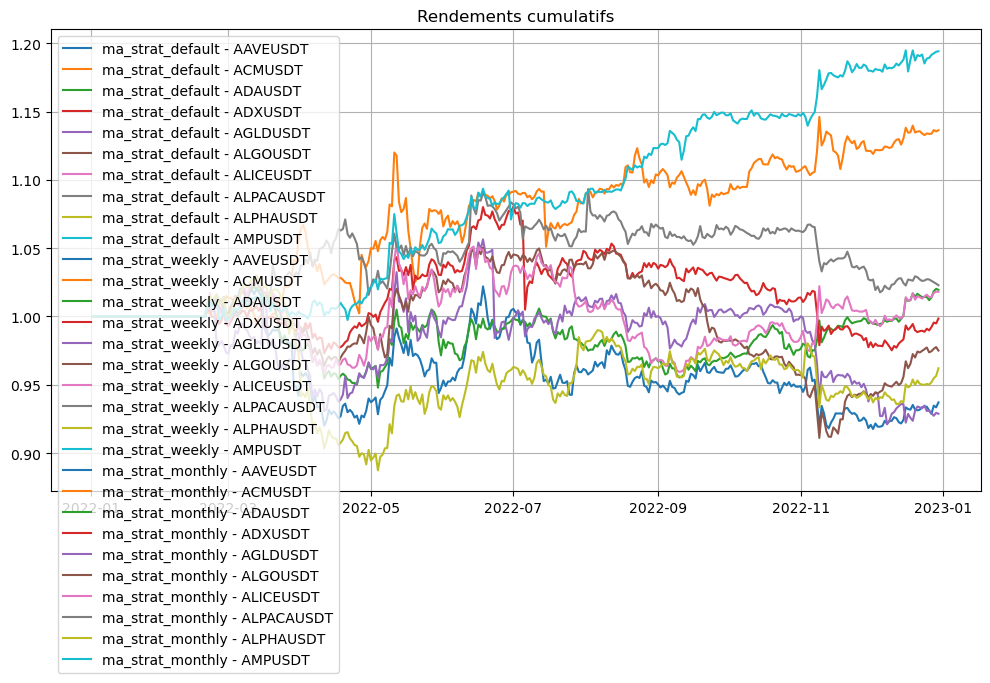

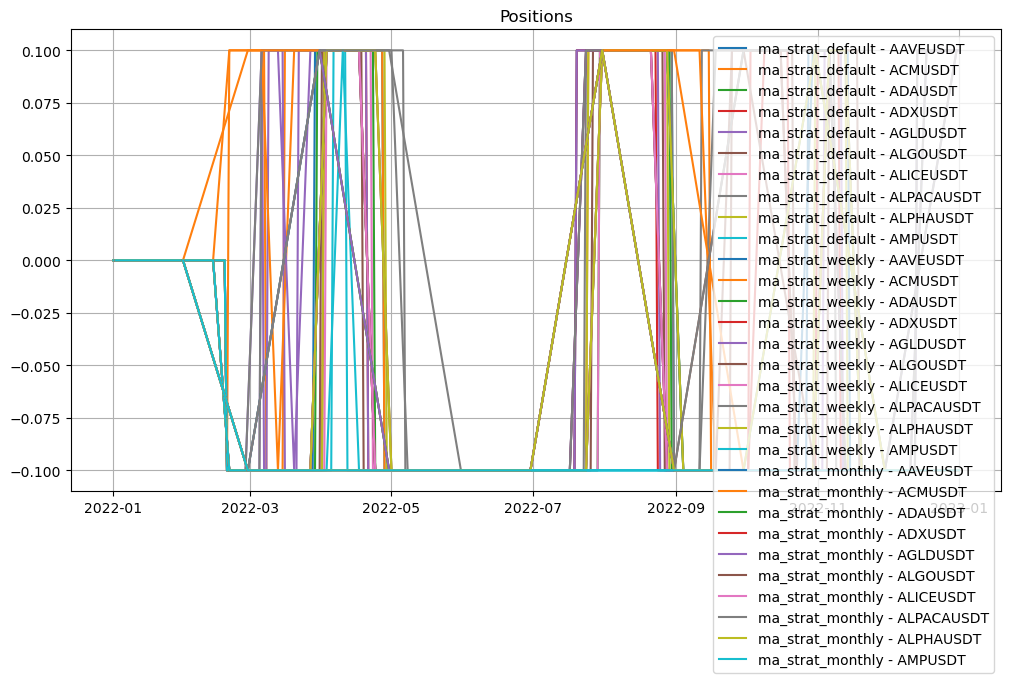

In [9]:
# Visualize results
backend = 'matplotlib' # 'plotly' # 'matplotlib' # 'seaborn'

# Plot individual strategies
manager.plot_all_strategies(backend=backend)


In [6]:
# Plot individual strategies
#manager.plot_strategy(strategy_name="ma_strat_default",backend=backend)

In [7]:
# Compare all strategies
manager.compare_strategies(backend=backend)
